<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/gpt-neo/661_GPT_Neo_SST2_ZSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-Neo SST-2
This notebook will prompt a pretrained GPT-Neo on the Stanford Sentiment Treebank dataset via Zero Shot Prompting.

## Setup

In [1]:
!pip install datasets transformers torch scikit-learn matplotlib seaborn

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Dataset and Model

In [2]:
# Load the SST-2 dataset and the model/tokenizer
dataset = load_dataset("glue", "sst2")
model_name = "EleutherAI/gpt-neo-2.7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

## Evaluation

In [3]:
def classify_review(review):
    prompt = f"Classify the sentiment of this review as either positive or negative: '{review}'\nSentiment:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Identify the logits for the tokens 'positive' and 'negative'
    logits = outputs.logits[0, -1, :]
    positive_id = tokenizer.encode("positive", add_special_tokens=False)[0]
    negative_id = tokenizer.encode("negative", add_special_tokens=False)[0]

    # Extract probabilities
    probabilities = torch.softmax(logits, dim=-1)
    positive_prob = probabilities[positive_id].item()
    negative_prob = probabilities[negative_id].item()

    # Classify based on higher probability
    return 1 if positive_prob > negative_prob else 0

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset["validation"]):
    review = sample["sentence"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(review)
    predicted_labels.append(predicted_label)

    if i % 100 == 0:
        print(f"Processed {i} reviews...")

Processed 0 reviews...
Processed 100 reviews...
Processed 200 reviews...
Processed 300 reviews...
Processed 400 reviews...
Processed 500 reviews...
Processed 600 reviews...
Processed 700 reviews...
Processed 800 reviews...


## Graphs and Table

Zero-shot accuracy on the validation set: 52.06%
Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.02      0.05       428
    positive       0.52      1.00      0.68       444

    accuracy                           0.52       872
   macro avg       0.76      0.51      0.36       872
weighted avg       0.75      0.52      0.37       872



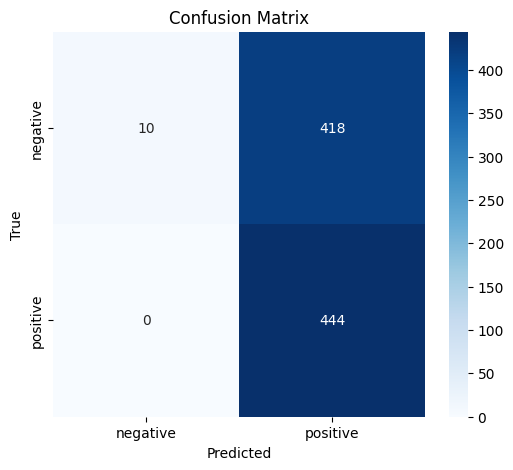

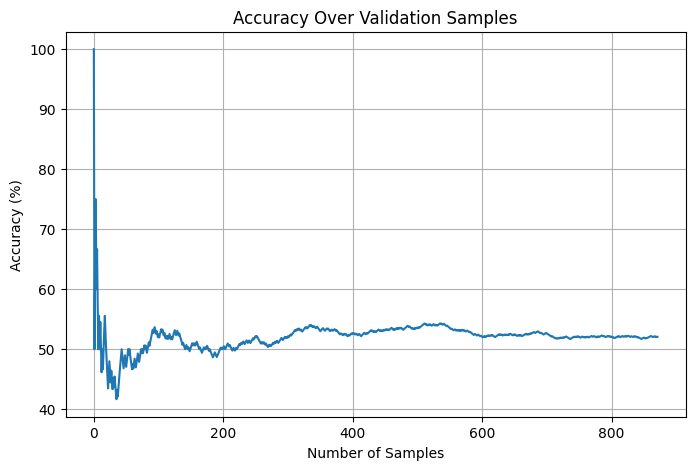

In [4]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Zero-shot accuracy on the validation set: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["negative", "positive"]))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

# GPT-Neo SST-2 ChatGPT Prompt
This portion of the notebook will prompt a pretrained GPT-Neo on Stanford Sentiment Treebank dataset using prompt generated by ChatGPT.

In [5]:
def classify_review(review):
    prompt = f"Here is a review: '{review}'\nBased on the content of this review, determine the sentiment. Reply with either 'positive' or 'negative'. Sentiment:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Identify the logits for the tokens 'positive' and 'negative'
    logits = outputs.logits[0, -1, :]
    positive_id = tokenizer.encode("positive", add_special_tokens=False)[0]
    negative_id = tokenizer.encode("negative", add_special_tokens=False)[0]

    # Extract probabilities
    probabilities = torch.softmax(logits, dim=-1)
    positive_prob = probabilities[positive_id].item()
    negative_prob = probabilities[negative_id].item()

    # Classify based on higher probability
    return 1 if positive_prob > negative_prob else 0

true_labels = []
predicted_labels = []

for i, sample in enumerate(dataset["validation"]):
    review = sample["sentence"]
    true_label = sample["label"]

    true_labels.append(true_label)

    predicted_label = classify_review(review)
    predicted_labels.append(predicted_label)

    if i % 100 == 0:
        print(f"Processed {i} reviews...")

Processed 0 reviews...
Processed 100 reviews...
Processed 200 reviews...
Processed 300 reviews...
Processed 400 reviews...
Processed 500 reviews...
Processed 600 reviews...
Processed 700 reviews...
Processed 800 reviews...


Zero-shot accuracy on the validation set: 50.92%
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       428
    positive       0.51      1.00      0.67       444

    accuracy                           0.51       872
   macro avg       0.25      0.50      0.34       872
weighted avg       0.26      0.51      0.34       872



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


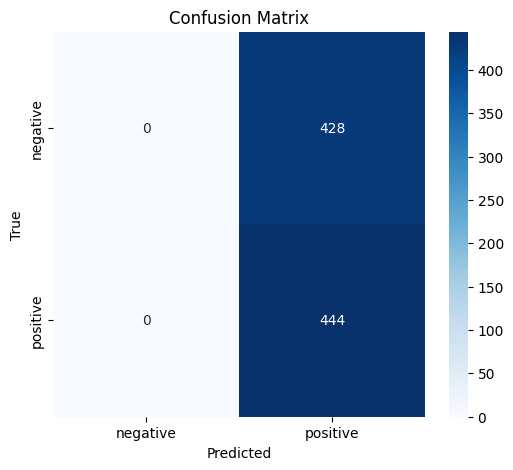

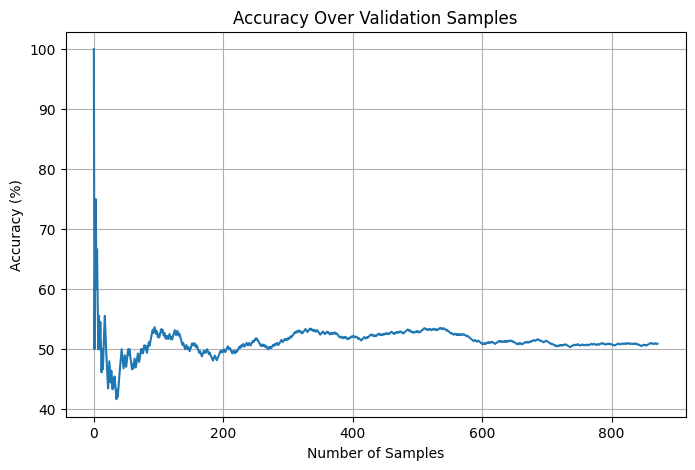

In [6]:
# Calculate accuracy
accuracy = sum([1 if p == t else 0 for p, t in zip(predicted_labels, true_labels)]) / len(true_labels) * 100
print(f"Zero-shot accuracy on the validation set: {accuracy:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["negative", "positive"]))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy graph
accuracies = np.cumsum(np.array(true_labels) == np.array(predicted_labels)) / np.arange(1, len(true_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()